# Milestone3: Explatory Analysis and Initial Results (deadline: 22.04 noon)

## 1. Define 'rhythimc flow'

### 1-1. Initial ideas

In the previous milestone, we mentioned that we aim to compare the rhythmic flow of rap music in different genres, in particular, gangsta-rap and old-school rap, and discover and compare the ‘norm’ of each subgenre through statistical analysis. Furthermore, we mentioned that we are going to define the 'rhythmic flow' in two ways: one based on rests, and one based on phrasal breaks.

However, after some deeper analysis on the MCFlow dataset, we concluded that 'rest' notation in the dataset is too ambigious to be a definitive criteria of flow. Thus, for our initial explatory analysis, we focused more on phrase-based distiction of 'flow'. If a lyric breaks down into sub-phrases, or followed by a new phrase, marked with punctuation marks as period, comma, etc, a new 'flow' starts.


### 1-2. Generalized & Simplified statistics of flow
Before taking a deeper analysis on individual patterns of flows, we propose several statistics to illustrate rhythmic flows of each genre in general. Through these general analysis, we are trying to discover general differences or similarities that different genres of rap music have. Those are:   
- Average syllabic length (in seconds): How fast MCs sing (or rap). Illustrates not only the 'talkativeness' of songs, but also their accuteness. For example, four 4th notes and four 8th note repectively followed by an 8th rest sounds quite differently in rap. The former gives more of relaxed sentiment, whereas the latter conveys some aggression. 

- Tempo: Overall speed of songs. Although speed of rap is mainly determined by the MCs and syllabic density rather than its actual tempo, still its tempo can illustrate the overall speed of instrumentals. 

- Syllabic onsets per phrase: Length of phrases. Generally, longer phrases are performed relentlessly, giving accerlerations and dramatic effects of that specific part. 

- Beats per phrase: Another lengths of phrases. This adds up the IOIs within each phrase. 


- Metric position of rhyme: Where rhymes occur within a measure. A wide spectrum of rhyme positions increases irregularities of songs, whereas a narrow spectrum makes songs somewhat predictable.

- Metric position of start or end point of phrase: Silmilar to the metric positions of rhyme. Whereas rhyme is more intuitive, sonic feature, start or end points of phrases are semantic feature, highly related to lyrics.


## 2. Encode LogicPro-tapped XML data into Humdrum format

In order to add the inter-cultural or inter-lingual feature to our project, we added a collection of French raps to our dataset. The songs are encoded in XML format by using LogicPro. After such process, the xml files are converted into .txt file by using our own xmlparser, which is stored in another directory in this repository. 

So far 12 songs are xml-encoded. Although we wrote XML parser that automates the translation process into humdrum format, we are still handling some corner cases in handling rests and calculating IOIs. Thus, sadly, we have only two French raps that are completely ready for the analysis. 

### Update (29.04)
French rap dataset is updated. Now we have 10 songs. There were still some missing notes, so we manually fixed them. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from scipy.stats import entropy
from itertools import compress
from matplotlib.ticker import PercentFormatter
from itertools import groupby
from operator import itemgetter


## 3. Experiments and Analysis 

### 3-1. Define the modules

In [22]:
# modules to define the HumdrumSummary class object


def check_measure_validity(df, measures, meter):
    # check if all the measures have the exact number of beats required for each measure, which is specified in the meter
    
    invalid_measures = []
    for i in range(len(measures)-1):
        snippet = df.loc[measures[i]+1: measures[i+1]-1]
        if snippet['**recip'].sum() != meter[0] : invalid_measures.append(df['**recip'].loc[measures[i]]) 
    return invalid_measures


def handle_metadata(df, metadata):
    # for MCflow datasets. not appicable for the manually-encoded french raps
    # read and parse the metadata lines.
    
    if metadata:
        tempo = int(df['**recip'][df['**recip'].apply(lambda x: '*MM' in x)].unique()[0].strip('*MM')) 
        meter = tuple(map(lambda x: int(x), \
                         df['**recip'][df['**recip'].apply(lambda x: '/' in x)].unique()[0].strip('*M').split('/')))
        df = df[df['**recip'].apply(lambda x: '*M' not in x)]
    else:
        tempo = 95
        meter = (4,4)
    return (df, tempo, meter)


def handle_pickup(df, meter):
    # for MCflow dataset
    # After some standarized methods are made in XMLparser, may be applicable to the French dataset as well.
    # if a verse starts with a syncopated pickup measure, handle the rests right before the start of the verse.
    
    df['pickup'] = False

    verse_idx = df[df['**recip'].apply(lambda x: '>Verse' in x)].index
    measure_idx = df[df['**recip'].apply(lambda x: '=' in x)].index
    valid_lyrics = df[df['**lyrics'].apply(lambda x: x!='.')].index.difference(verse_idx).difference(measure_idx)

    for i in verse_idx:
        verse_start = valid_lyrics[valid_lyrics > i][0]
        df.loc[i:verse_start-1,'pickup'] = True

        
    df = df[df['**recip'].apply(lambda x: x[0] in '0123456789=')]
    df['**recip'] = df['**recip'].apply(lambda x: _convert_recip(string=x,ref=meter[1]))             

    if (df['**recip'] == '=0').any():
        pickup_start = df[df['**recip'].apply(lambda x: x == '=0')].index
        pickup_end = df[df['**recip'].apply(lambda x: x == '=1')].index

        for i, idx in enumerate(pickup_start):
            snippet = df.loc[idx+1:pickup_end[i]-1]
            snippet['**recip'][snippet['**lyrics']=='.'] = 0
            rest = meter[0] - snippet['**recip'][snippet['**lyrics']!='.'].sum()
            snippet['**recip'].at[idx+1] = rest

    return df


def _convert_recip(string, ref):
    # the most important module
    # read the beats written in notes, return the length of beat, Expressed as multiples of the reference beat.
    # example1: 4/4 music, 16th note -> returns 0.25
    # example2: 4/4 music, dotted 2th note -> returns 3
    
    
    if '=' in string:
        return string
    elif '%' in string:
        (num,coef) = list(map(lambda x: int(x), string.split('%')))
        return coef * ref / num
    else:
        try:
            dots = string.count('.')
            num = int(string.strip('.'))
            coef = 1
            for d in range(dots):
                coef += 1 / (2**(d+1))

            return coef * ref / num
        except:
            return string
        
def get_ioi(df):
    # handle IOIs
# merge consecutive rests
    ioi_df = df.copy()

    # remove pickups
    ioi_df = ioi_df[~ioi_df.pickup]

    ioi_df = ioi_df.reset_index(drop=True)

    # get rest index
    # get the notes just before.
    # merge

    rests_split = [list(map(itemgetter(1), g)) for k, g in \
                    groupby(enumerate(ioi_df[ioi_df['**lyrics'] == '.'].index), lambda x: x[0]-x[1])]

    for rs in rests_split:
        if len(rs) > 1:
            #handle interal merge first
    #        print(ioi_df.loc[rs])
            total_rests = ioi_df.loc[rs,'**recip'].sum()
            ioi_df.loc[rs[:-1],'**recip'] = 0
            ioi_df.loc[rs[-1],'**recip'] = total_rests
            ioi_df.loc[rs]

    ioi_df = ioi_df[ioi_df['**recip']!=0].reset_index(drop=True)
    rests_idx = ioi_df[ioi_df['**lyrics'] == '.'].index
    for r in rests_idx:
        merged_rest = ioi_df.loc[r-1:r,'**recip'].sum()
        ioi_df.loc[r-1, '**recip'] = merged_rest
        ioi_df.loc[r-1, 'cum_recip'] = ioi_df.loc[r, 'cum_recip']

    ioi_df = ioi_df[ioi_df['**lyrics']!='.'].reset_index(drop=True)
    return ioi_df        

In [105]:
class HumdrumSummary():
    # class object to read each humdrum file and store neccesary data.
    
    def __init__(self, sample_path, metadata=True):

        raw_df =  pd.read_table(sample_path)
        df = raw_df[raw_df['**recip'].apply(lambda x: '!' not in x)]   

        df, tempo, meter = handle_metadata(df, metadata)
        
        
        df['**lyrics'] = df['**lyrics'].apply(lambda x:str(x))
        
        verses = df[df['**lyrics'].apply(lambda x: '>Verse' in x )].index

        for i in range(len(verses)-1):
            df.loc[verses[i]:verses[i+1]-1, '**verse'] = i+1
        df.loc[verses[-1]:, '**verse'] = len(verses)



        measures = df[df['**recip'].apply(lambda x: '=' in x)].index
        
        df = handle_pickup(df,meter)
        
        invalid_measures = check_measure_validity(df, measures,meter)#invalid_measures    

        df = df[df['**recip'].apply(lambda x: type(x) != str)]
        df = df[df['**recip'] != 0]
        df['cum_recip'] = df['**recip'].cumsum()
        df['breakpoints'] = df['cum_recip'][df['**break'].apply(lambda x: x in ['3','4'])].apply(lambda x: (x-df['**recip'].min()/4)%4)

        ioi_df = get_ioi(df)
        
        self.meter = meter
        self.df = df
        self.tempo = tempo
        self.syl_onsets = df[df['**lyrics']!='.'].shape[0]
        self.syllabic_rate = tempo / (60 * df['**recip'][df['**lyrics']!='.'].mean())
        self.ioi_rate = tempo / (60 * ioi_df['**recip'].mean())
        self.rhyme = df[df['**rhyme']!='.'].cum_recip.apply(lambda x: (x-df['**recip'].min()/4)%4)
        self.breakpoints = df['breakpoints']

        self.ioi_df = ioi_df
        self.raw_df = raw_df

        self.invalid_measures = invalid_measures
        self.lang = sample_path.split('/')[1]
        self.path = sample_path
        
        
        

        

In [24]:
francophone_dir = 'data/francophone/'

francophone_files = [
'IAM-Je danse le MIA.txt',
'MC Solaar-Hasta La Vista.txt',
'Lunatic-Pas le temps pour les regrets.txt',
'MC Solaar-Paradisiaque.txt',
'MC-Solaar-Obsolete.txt',
'NTM-Laisse pas trainer ton fils.txt',
'NTM-Ma Benz.txt',
"NTM-That's my people.txt",
"Passi-Le monde est a moi.txt",
"Sniper-Grave dans la roche.txt"
]


def clean_francophone(sample_file):
    sample_dest = francophone_dir + 'oldschool/' + f
    sample_path = francophone_dir + 'raw/' + f

    sample = pd.read_table(sample_path, header=None)
    sample = sample.rename(columns={0:'**recip',1:'**break',2:'**rhyme',3:'**lyrics'})
    verse_idx = list(sample[sample['**break'].apply(lambda x: '*>Verse' in x)].index)

    # find measure indicator
    measures_idx = list(sample[sample['**break'].apply(lambda x: '=' in x)].index)
    start_idx = list(sample[sample['**break'].apply(lambda x: x == '*>Verse1')].index)
    start_measure_idx = list(compress(measures_idx,list(map(lambda x: x < start_idx[0], measures_idx))))[-1]
    # find the closest measure indicator to the verse1 line
    #start_measure_idx
    sample = sample[sample.index > (start_measure_idx-1)]#.head(30)

    #check the rows with 1th note
    #sample[sample['**recip'].apply(lambda x: '>' in x)]
    sample = sample[sample['**recip'].apply(lambda x: x != '1')]



    sample['**lyrics'].at[sample['**lyrics']=='R'] = '.'

    #sample['**break'] = sample['**break'].apply(lambda x: int(x))
    sample['**break'].at[sample['**break'] == '2'] = '3'
    sample['**break'].at[sample['**break'] == '1'] = '4'
    sample['**break'].at[sample['**break'] == '0'] = '.'

    sample['**rhyme'].at[sample['**rhyme'] == '0'] = '.'
    sample['**rhyme'].at[sample['**rhyme'] == '1'] = 'A'


    sample.to_csv(sample_dest, sep='\t', index=False)



reset = True
if reset:

    # check the integrities of manually-encoded files

    for f in francophone_files:
        clean_francophone(f)

            
    for f in francophone_files:
        sample_path = francophone_dir + 'oldschool/' + f
        sample = HumdrumSummary(sample_path, metadata=False)
#        print(sample.raw_df.head())




/Users/haeeunkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
# load sample data

anglophone_dir = 'data/anglophone/'

gangsta_files = ['50Cent_CandyShop.rap',
'50Cent_DiscoInferno.rap',
'50Cent_InDaClub.rap',
'50Cent_JustALilBit.rap',
'50Cent_P.I.M.P..rap',
'Eminem_TheWayIAm.rap',
'JayZ_CanIGetA.rap',
'JayZ_HolyGrail.rap',
'JayZ_NiggasInParis.rap',
'KanyeWest_Clique.rap',
'KanyeWest_Mercy.rap',
'LilWayne_AMilli.rap',
'LilWayne_GotMoney.rap',
'LilWayne_Lollipop.rap',
'Ludacris_HowLow.rap',
'Ludacris_MoveBitch.rap',
'Ludacris_StandUp.rap',
'Ludacris_WhatsYourFantasy.rap',
'Mims_ThisIsWhyImHot.rap',
'MissyElliott_WorkIt.rap',
'Nelly_Grillz.rap',
'SnoopDogg_LayLow.rap',
'SnoopDogg_Woof.rap',
'T.I._LiveYourLife.rap',
'T.I._WhatYouKnow.rap',
'TerrorSquad_LeanBack.rap']

oldschool_files=[
'2pac_CaliforniaLove.rap',
'2pac_HowDoUWantIt.rap',
'2pac_IGetAround.rap',
'2pac_PapazSong.rap',
'2pac_SoManyTears.txt',
'DrDre_NuthinButAGThang.rap',
'Eminem_RockBottom.rap',
'Eminem_TheRealSlimShady.rap',
'JayZ_CantKnockTheHustle.rap',
'KrisKross_Jump.rap',
'LLCoolJ_HeyLover.rap',
'LLCoolJ_INeedLove.rap',
'NotoriousBIG_BigPoppa.rap',
'NotoriousBIG_GoingBackToCali.rap',
'NotoriousBIG_Hypnotize.rap',
'NotoriousBIG_Juicy.rap',
'NotoriousBIG_MoMoneyMoProblems.rap',
'NotoriousBIG_OneMoreChance.rap',
'NotoriousBIG_SkysTheLimit.rap',
'Run-D.M.C._DownWithTheKing.rap',
'SnoopDogg_GinAndJuice.rap',
'WarrenG_Regulate.rap',
'WillSmith_GettinJiggyWitIt.rap',
'WillSmith_Summertime.rap',
'WillSmith_WildWildWest.rap',
'Wreckx-N-Effect_RumpShaker.rap',
]

In [26]:
def phrase_based(df, clean_rest=False):
    # break the humdrum data into phrases.
    # according to the description on the website and our common knowledge of interpreting the lyrics,
    # we concluded that only level 3,4 break are meaningful.
    sample_clean = df
    if clean_rest:
        sample_clean = sample_clean[sample_clean['**lyrics']!='.']

    breaks_idx = sample_clean[sample_clean['**break'].apply(lambda x: x in ['3','4'])].index


    # create a new dataframe that will show the flowwise analysis on this song
    sample_flowwise = pd.DataFrame(columns=['recip','lyric'])


    for i in range(breaks_idx.shape[0]-1):
        (start, end) = (breaks_idx[i], breaks_idx[i+1])
        snippet = sample_clean.loc[start:end-1]
        sample_flowwise.at[i,'recip'] = snippet['**recip'].values
        sample_flowwise.at[i,'lyric'] = ' '.join(snippet['**lyrics'].values)

    maxlen = sample_flowwise.lyric.apply(lambda x: len(x)).max()
    pd.set_option('display.max_colwidth', maxlen)
    return sample_flowwise
    
        
def flowwise_visualize(sample_obj):
    # displays the flow of a given rap.
    # helper fuction. does not give any significance yet.
    # expected to give some visual insights to us.
    
    sample = phrase_based(sample_obj.df)
    maxlen = sample.recip.apply(lambda x: len(x)).max()
    sample.recip = sample.recip.apply(lambda x: np.concatenate([x, [0]* (maxlen - len(x))]))
    s = pd.DataFrame(item for item in sample.recip)

    viz = s.plot(kind='bar', stacked=True, legend=None)
    plt.xticks([])
    plt.title('visual representation of flows of {0}'.format(sample_obj.path))
    plt.xlabel('flows (phrases)')
    plt.ylabel('# of beats per flow')
    plt.show()
#    return viz

### 3-2. Execution

In [106]:
humdrum_dict = {anglo_os_dir:[], anglo_gs_dir:[], franco_os_dir:[]}


def summarize_humdrum(sample_dir, sample_filename):
    metadata = False if sample_dir == franco_os_dir else True
    sample_path = sample_dir + '/' + sample_filename
    
    try:

        sample = HumdrumSummary(sample_path, metadata)
#        print('here')
        humdrum_dict[sample_dir].append(sample)

    except:
        error.append(sample_dir + '/' + f)
        pass
    


In [46]:
francophone_dir+'oldschool'

'data/francophone/oldschool'

In [107]:
error = []

print('number of anglophone oldschool files to read: {0}'.format(len(oldschool_files)))
print('number of anglophone gangsta files to read: {0}'.format(len(gangsta_files)))
print('number of francophone oldschool files to read: {0}'.format(len(francophone_files)))

anglo_os_dir = anglophone_dir + 'oldschool'
anglo_gs_dir = anglophone_dir + 'gangsta'
franco_os_dir = francophone_dir + 'oldschool'

directories = [(anglo_os_dir, oldschool_files),\
             (anglo_gs_dir,gangsta_files),
             (franco_os_dir,francophone_files)]

for d in directories:
    for f in d[1]:
        summarize_humdrum(d[0],f)

print('Check : File not read: {0}'.format(len(error)))

number of anglophone oldschool files to read: 26
number of anglophone gangsta files to read: 26
number of francophone oldschool files to read: 10


/Users/haeeunkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/haeeunkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/haeeunkim/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.

Check : File not read: 0


### 3-3. General Analysis

Firstly, we will investigate the statistical analysis of the general features of flow, mentioned in section 1-2.

Usally, boxplots are more suitable in illustrating the overall distributions. However, since we have relatively small number of samples, we also use general histogram to get the detailed idea on each distribution. 

### A. Song-centered analysis
In this part, we have one datapoint for each song. For the moment, we don't have tempos of french songs, which is a necessary feature here. So francophone songs are negleted here.

1. Syllable lengthes

Average length (in seconds) of syllabic onset for each song. In the attribute definition, rests are neglected and not taken into account, so that it can illustrate the accuteness of notes played with short syllables and long rests. Later, we can try similar calculatation on IOIs, getting the density of syllables throught the song.

In [349]:
labels = list(humdrum_dict.keys())

def plot_analysis(func, option=0):
    data = {}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    

    for i,h in enumerate(humdrum_dict):
        if option == 0:
            data[h] = list(map(func,humdrum_dict[h]))
        elif option == 1:
#            print(list(map(func,humdrum_dict[h])))
            data[h] = (sum(list(map(func,humdrum_dict[h])), []))
        ax1.hist(data[h], weights=np.ones(len(data[h])) / len(data[h]), \
                 alpha=0.5, label=list(humdrum_dict.keys())[i])                     
        ax2.boxplot(data[h], positions=[i]) 

    

    ax1.yaxis.set_major_formatter(PercentFormatter(1))
    ax1.legend()
    
    plt.sca(ax2)
    plt.xticks(range(0,len(labels)), labels, rotation = 0)
    
    ax1.set_ylabel('percentage (within genre)')
    ax2.set_xlabel('genre')

    return fig, (ax1, ax2)


def plot_entropy_analysis(func):
    data = {}

    fig, axs = plt.subplots(1, 3, figsize=(16,5), sharey=True)
    

    for i,h in enumerate(humdrum_dict):
        data[h] = (sum(list(map(func,humdrum_dict[h])), []))
        axs[i].hist(data[h], weights=np.ones(len(data[h])) / len(data[h]), \
                 alpha=0.5, label=list(humdrum_dict.keys())[i]) 
        axs[i].yaxis.set_major_formatter(PercentFormatter(1))
        axs[i].set_title('{0} : entropy {1}'.format(labels[i],np.round(entropy(data[h]),3)))
        plt.sca(axs[i])

    return fig, axs


def plot_label(fig, axs, feature, unit):
    if len(axs) == 2:
        axs[0].set_title('distribution of ' + feature + '(histogram)')
        axs[0].set_xlabel(unit)
        axs[1].set_title('distribution of ' + feature + '(boxplot)')
        axs[1].set_ylabel(unit)
        
    elif len(axs)== 3:
        for i in range(len(humdrum_dict)):
            axs[i].set_xlabel(unit)
            


        plt.suptitle('distribution of ' + feature)


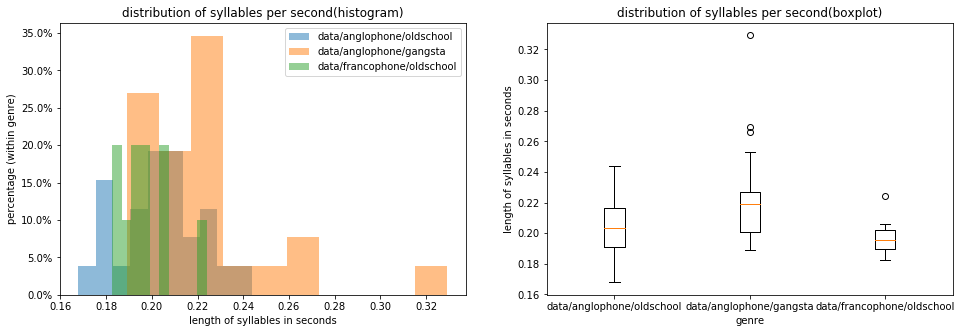

In [339]:

func = lambda x: 1/ x.syllabic_rate

feature = 'syllables per second'
unit = 'length of syllables in seconds'


fig, (ax1, ax2) = plot_analysis(func)
plot_label(fig, (ax1, ax2), feature, unit)


plt.show() 



Both genres have similar median and interquatile range. Still, syllables in old school raps tends to be shorter than their gangsta counterparts

2. tempo

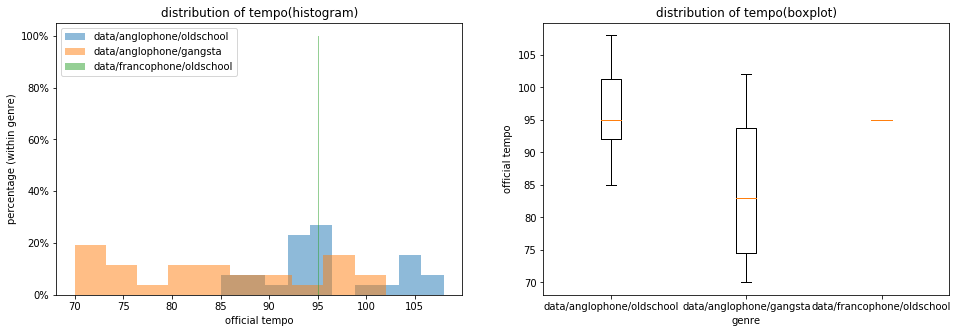

In [342]:
func = lambda x: x.tempo

feature = 'tempo'
unit = 'official tempo'


fig, (ax1, ax2) = plot_analysis(func)
plot_label(fig, (ax1, ax2), feature, unit)

plt.show() 
#print('median differ by {:.2f} %'.format(100*np.abs(medians[0]-medians[1])/min(medians)))


Anglophone oldschool raps have faster tempo that their gangsta counterpart. The distribution is more constrained in the oldschool. On the other hand, tempo of anglophone gangsta is slower, with larger variance.

Again, this graph can be supplemented by the syllabic density analysis by using IOIs.


### B. Phrase-centered analysis
In this part, we have one datapoint for each phrase in the set. For example, if there are two songs in a dataset, one with 10 phrases and one with 20 phrases, the total number of datapoints is 30. We conducted our analysis this way because we didn't want to ignore details of various phrases (or 'flows'). In such analysis, however, there is a possiblity that songs with longer phrases being overrepresented.

To interpret the phrase-centered analysis more securely and avoid possible over/under-representation, we start by displaying the distribution of number of phrases per song in each set of data.


1. Number of phrases for each song

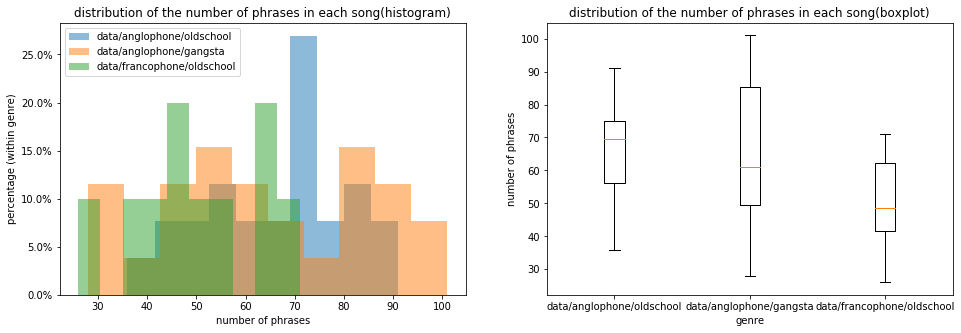

In [343]:
func = lambda x: x.breakpoints.dropna().shape[0]
feature = 'the number of phrases in each song'
unit = 'number of phrases'

fig, (ax1, ax2) = plot_analysis(func)
plot_label(fig, (ax1, ax2), feature, unit)

plt.show()


The distribution of the francophone dataset deviates a lot from the anglophone datasets. Like other results, median for the anglophone oldschool and gangsta differs by ~10%, and the variance is higher in gangsta.
French songs had significantly less phrases per each song

2. Number of syllables per phrase

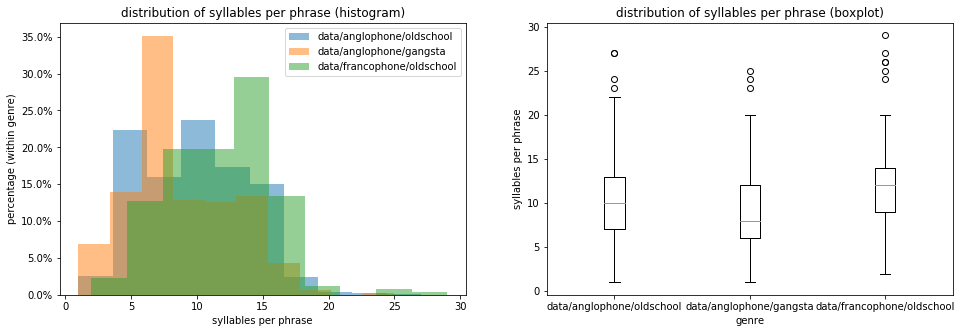

In [344]:
func = lambda x: phrase_based(x.df)['recip'].apply(lambda y: len(y)).tolist()



fig, (ax1, ax2) = plot_analysis(func,option=1)



feature = 'syllables per phrase '
unit = 'syllables per phrase'


plot_label(fig, (ax1, ax2), feature, unit)

plt.show()



No significant difference is observed here.

3. Beats per phrase: 

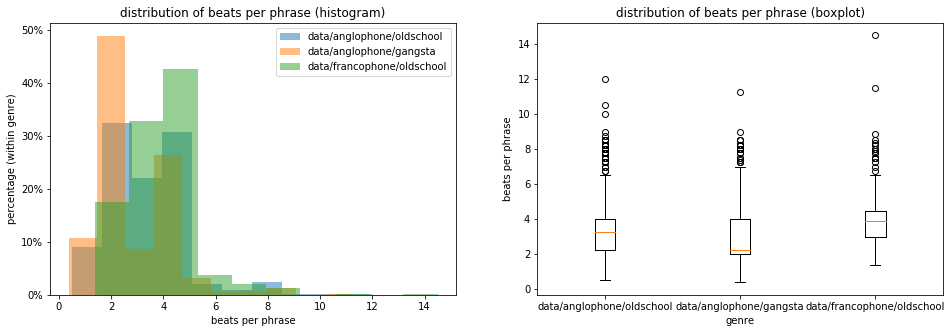

In [345]:
func = lambda x: phrase_based(x.df)['recip'].apply(lambda y: sum(y)).tolist()



fig, (ax1, ax2) = plot_analysis(func,option=1)



feature = 'beats per phrase '
unit = 'beats per phrase'


plot_label(fig, (ax1, ax2), feature, unit)


plt.show()

In all cases, peaks appear around the multiples of 2 (half a measure). The distribution differs between three genres. In anglophone gangsta, phrases appears to be quite short, taking only two beats at most of the cases. In anglophone oldschool, beats per phrase is rather evenly distributed between half measure and whole measure. Likewise, francophone oldschool is more concentrated on 4-beats phrase.

### C. Measure-centered Analysis

Compute the metrical position of certain feature (rhyme, phrase starting points, etc) within the song, and aggregate the data. If the distribution is even, we can say that that specific genre has higher degree of freedom in placing rhymes and starting phrases. To get the general idea of 'degree of freedom', we computed entropies of features in each dataset. This is how they characterized phrasing styles of different MCs in MCflow dataset.

1. Starting point of phrases

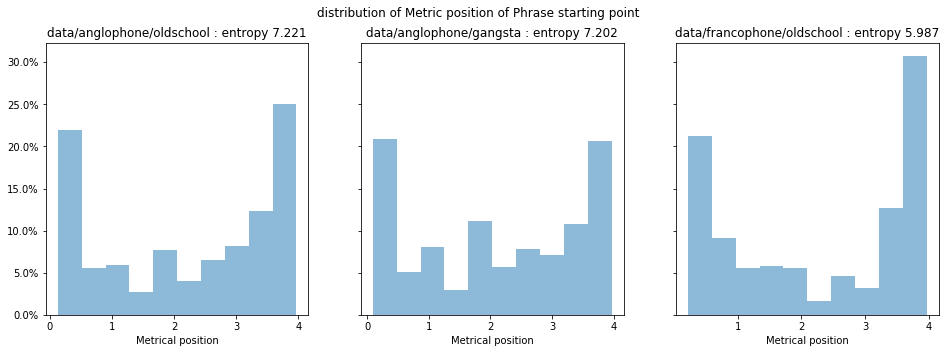

In [350]:
func = lambda x: x.breakpoints.dropna().tolist()

fig, axs = plot_entropy_analysis(func)


feature = 'Metric position of Phrase starting point'
unit = 'Metrical position'


plot_label(fig, axs, feature, unit)
plt.show()

In all genres, phrases tend to start at the first or last metrical position of measure. Considering the incompleteness of the francophone dataset, no significant or reliable difference is observed.

2. Rhyme positions

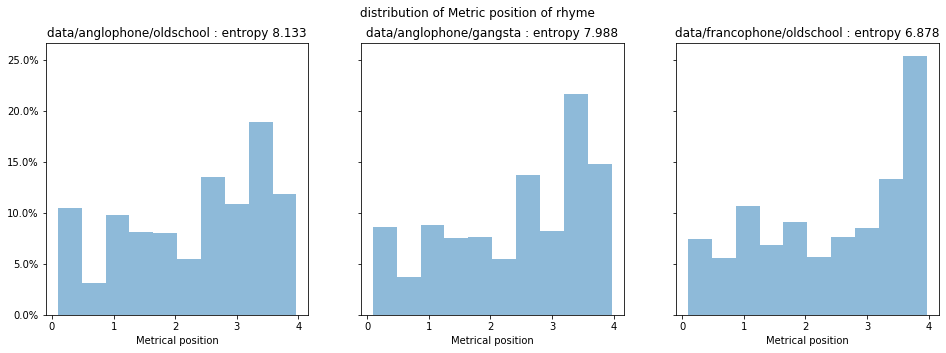

In [351]:
func = lambda x:x.rhyme.tolist()

fig, axs = plot_entropy_analysis(func)


feature = 'Metric position of rhyme'
unit = 'Metrical position'


plot_label(fig, axs, feature, unit)
plt.show()

In all genres, rhymes tend to occur at the ast metrical position of measure. Considering the incompleteness of the francophone dataset, no significant or reliable difference is observed.

## 4. Discussions and Interpretaions


So far we have found out following differences: 

- Anglophone oldschool : accute, faster tempo, generally shows smaller variance in the feature we looked at. Longer phrases.
- Anglophone Gangsta: obtuse, slower tempo, generally shows larger variance in the feature we looked at. Very short phrases.
- (Francophone oldschool: not enough datapoints)

The most significant difference found here is the 'standard' length of phrase (flow) in terms of beats. Seeing the distribution of the length of flow, we can reasonably choose the 'representative flow' of each genre, by filtering through the beat length, which will be useful in later analysis.

However, even though these are good illustrations of different genres of rap music in general, we were not able to conduct any 'deeper' analysis on flows and discovering 'norm flow' for each genre. This is largely due to the result of analysis C. Initially, we aimed to discover different distributions in rhyme positions and phrase string points in different genres, but it turned out that there is no significant difference.

This leads us to conduct more detailed analysis on each phrase(flow). How are IOIs distributed within a flow? What can be the possible rhyme position of a following flow? How frequent such flow appear throughout the song or genre?
One of the obvious ways to conduct the abovementioned points is to statically analyze the sequence of syllabic onsets (or IOIs) through Markov model.

Besides, we can select 'representative songs' per each genre, visualize their flow by marking different lengths of syllabic onsets (or IOIS) within a flow. The example is just below:

In this figure, all the syllabic onsets and rests are marked in different color, relative to the reference beat. Each bar indicates each flow.
Here, the figure intuitively illustrates that the majority of its flows are 4-beat or 2-beat long, which reflects the results of part 3.B.3. Moreover, the internal distribution of syllabic onsets is very regular as well.

Through such final analysis we aim to:
- clarify general difference between anglophone oldschool/anglophone gangsta/francophone oldschool rap
- show (statistically) standard flow of each genre.
- state the inter-genre or inter-cultural (or inter-linguistical) influence on rap flow: Is francophone oldschool rap more similar to anglophone oldschool rap, or anglophone gangsta rap, or neither?


## 5. (Tentative) Things to do before the final milestone
### More general analysis to be done
- fix the xmlparser, so that we have a complete humdrum set of francophone raps. -> done
- compute syllabic density ('talktativeness) of each song, by computing average IOIs. -> done
- compute note distribution of each song.

### Intra-phrase analysis
- markov analysis on IOIs within phrase
- markov analysis on rhyme positions within phrase

In [236]:
# possible ioi lengths -> to get the markov matrix 



transitions_ = []
for h in humdrum_dict:
#    print(h)
    temp = np.concatenate(list(map(lambda x: x.df['**recip'],humdrum_dict[h])))
    transitions_.append(temp)

    
from itertools import chain



transitions_ = list(chain(*transitions_))#print list(chain(*A))
# or better: (available since Python 2.6)
#print list(chain.from_iterable(A))
transitions = np.unique(transitions_)
print(transitions)
print(len(transitions))

pd.Series(transitions_).value_counts().head(10).index

[0.125      0.16666667 0.25       0.33333333 0.375      0.5
 0.625      0.75       0.875      1.         1.125      1.25
 1.5        1.75       2.         2.25       2.5        2.75
 3.         3.125      3.25       3.375      3.5        3.625
 3.75       4.        ]
26


Float64Index([0.25, 0.5, 0.125, 0.375, 0.75, 1.0, 0.16666666666666666, 3.5,
              2.0, 3.0],
             dtype='float64')

In [231]:
# possible ioi lengths -> to get the markov matrix 



transitions_ = []
for h in humdrum_dict:
#    print(h)
    temp = np.concatenate(list(map(lambda x: x.ioi_df['**recip'],humdrum_dict[h])))
    transitions_.append(temp)

    
from itertools import chain



transitions_ = list(chain(*transitions_))#print list(chain(*A))
# or better: (available since Python 2.6)
#print list(chain.from_iterable(A))
transitions = np.unique(transitions_)
print(transitions)
print(len(transitions))

pd.Series(transitions_).value_counts()

[0.125      0.16666667 0.25       0.33333333 0.375      0.5
 0.625      0.75       0.875      1.         1.125      1.25
 1.375      1.5        1.75       1.875      2.         2.25
 2.375      2.5        2.75       3.         3.25       3.5
 3.75       4.         4.25       4.5        4.75       7.75      ]
30


0.250000    22470
0.500000     6674
0.750000     1536
0.125000     1477
0.375000      898
1.000000      579
0.166667      262
1.250000      156
0.625000       95
1.500000       76
0.875000       50
1.750000       33
2.000000       22
0.333333       22
4.000000       15
2.500000       12
1.125000       10
3.750000        8
2.750000        6
4.250000        6
2.250000        5
1.375000        5
3.250000        4
3.000000        3
3.500000        2
7.750000        1
4.500000        1
1.875000        1
4.750000        1
2.375000        1
dtype: int64

In [208]:
import seaborn as sns

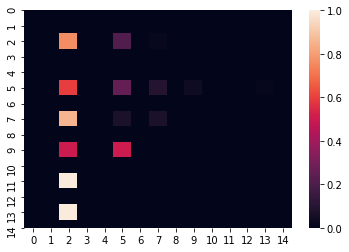

IndexError: index 0 is out of bounds for axis 0 with size 0

In [209]:
for h in humdrum_dict:

    markov_list = phrase_based(humdrum_dict[h][0].ioi_df)['recip'].tolist()

    _T = []
    for m in markov_list:
        _T.append(list(map(lambda x: np.argwhere(transitions == x)[0][0],m)))

    M = np.zeros((transitions.shape[0],transitions.shape[0]))

    T = np.concatenate(_T)

    #create matrix of zeros

    #M = [[0]*4 for _ in range(4)]

    for (i,j) in zip(T,T[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        n = sum(row)
        if n > 0:
            row[:] = [f/sum(row) for f in row]



    probs = M
    sns.heatmap(M)
    plt.show()
    

In [ ]:

'''
df['pickup'] = False

if (df['**recip'] == '=0').any():
    pickup_start = df[df['**recip'].apply(lambda x: x == '=0')].index
    pickup_end = df[df['**recip'].apply(lambda x: x == '=1')].index

    for i, idx in enumerate(pickup_start):
        snippet = df.loc[idx+1:pickup_end[i]-1]
        snippet['**recip'][snippet['**lyrics']=='.'] = 0
        rest = meter[0] - snippet['**recip'][snippet['**lyrics']!='.'].sum()
        snippet['**recip'].at[idx+1] = rest


verse_idx = df[df['**recip'].apply(lambda x: '>Verse' in x)].index
measure_idx = df[df['**recip'].apply(lambda x: '=' in x)].index
valid_lyrics = df[df['**lyrics'].apply(lambda x: x!='.')].index.difference(verse_idx).difference(measure_idx)

for i in verse_idx:
    verse_start = valid_lyrics[valid_lyrics > i][0]
    df.loc[i:verse_start-1,'pickup'] = True

    


df = df[df['**recip'].apply(lambda x: x[0] in '0123456789=')]
meter = (4,4)
df['**recip'] = df['**recip'].apply(lambda x: _convert_recip(string=x,ref=meter[1]))             

'''



'''# part of pickup_control


pickup_split = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(df[df.pickup].index), lambda x: x[0]-x[1])]

pickup_split

for v in pickup_split:
    #pickup_start = v[0]
    #pickup_end = v[-1]
    snippet = df.loc[v[0]:v[-1]]
    pickup_sum = snippet['**recip'].sum()
    df.loc[v[0]:v[-1], '**recip'] = 0
    df.loc[v[-1],'**recip'] = pickup_sum'''

'''# I think this won't be used really.

def measure_based(df):
    # break the humdrum data into measures.
    sample_clean = df

    breaks_idx = sample_clean[sample_clean['cum_recip'].apply(lambda x: x%4 == 0)].index + 1


    # create a new dataframe that will show the flowwise analysis on this song
    sample_flowwise = pd.DataFrame(columns=['recip','lyric'])


    for i in range(breaks_idx.shape[0]):
        if i == 0:
            (start, end) = (0, breaks_idx[0])
        else:
            (start, end) = (breaks_idx[i-1], breaks_idx[i])
        snippet = sample_clean.loc[start:end-1]
        sample_flowwise.at[i,'recip'] = snippet['**recip'].values
        sample_flowwise.at[i,'lyric'] = ' '.join(snippet['**lyrics'].values)

    maxlen = sample_flowwise.lyric.apply(lambda x: len(x)).max()
    pd.set_option('display.max_colwidth', maxlen)
    return sample_flowwise
    
error = []


def concat_units(sample_dir, sample_genre, sample_filename, summary, metadata=True):
    try:
        sample_path = sample_dir + sample_genre + '/' + sample_filename
        sample = HumdrumSummary(sample_path, metadata)

        summary['measure_based'].extend(measure_based(sample.df)['recip'].tolist())
        summary['phrase_based'].extend(phrase_based(sample.df)['recip'].tolist())

    except:
        error.append(sample_dir + sample_genre + '/' + f)
        pass
    
    


summary_units1 = {'measure_based':[],'phrase_based':[]}
summary_units2 = {'measure_based':[],'phrase_based':[]}
summary_units3 = {'measure_based':[],'phrase_based':[]}

print('number of anglophone oldschool files to read: {0}'.format(len(oldschool_files)))
print('number of anglophone gangsta files to read: {0}'.format(len(gangsta_files)))
print('number of francophone oldschool files to read: {0}'.format(len(francophone_files)))

for f in oldschool_files:
    concat_units(anglophone_dir, 'oldschool', f, summary_units1)

for f in gangsta_files:
    concat_units(anglophone_dir, 'gangsta', f, summary_units2)
    
for f in francophone_files:
    concat_units(francophone_dir, 'oldschool', f, summary_units3, metadata=False)
    
print('Check : File not read: {0}'.format(len(error)))


plt.hist(list(map(lambda x: sum(x), summary_units1['measure_based'])))
plt.show()
plt.hist(list(map(lambda x: sum(x), summary_units2['measure_based'])))
plt.show()
plt.hist(list(map(lambda x: sum(x), summary_units3['measure_based'])))
plt.show()'''